In [24]:
from hcipy import *
# from progressbar import progressbar

import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as ndimage
import time
import os

%matplotlib inline

# conda install -n <env_name> <package> for installing packages 
# virtual environment

## Setting up the pupil

you can take out the spider and the central obstruction

In [22]:
# Have to edit to include accurate parameters from the APF
telescope_diameter = 2.4 # meter
central_obscuration = 0.4 # meter
central_obscuration_ratio = central_obscuration / telescope_diameter
spider_width = 0.01 # meter

oversizing_factor = 16 / 15
num_pupil_pixels = 240 * oversizing_factor
pupil_grid_diameter = telescope_diameter * oversizing_factor #why?
pupil_grid = make_pupil_grid(num_pupil_pixels, pupil_grid_diameter)

aperture_generator = make_obstructed_circular_aperture(telescope_diameter,
    central_obscuration_ratio, num_spiders=4, spider_width=spider_width)

aperture = evaluate_supersampled(aperture_generator, pupil_grid, 4)

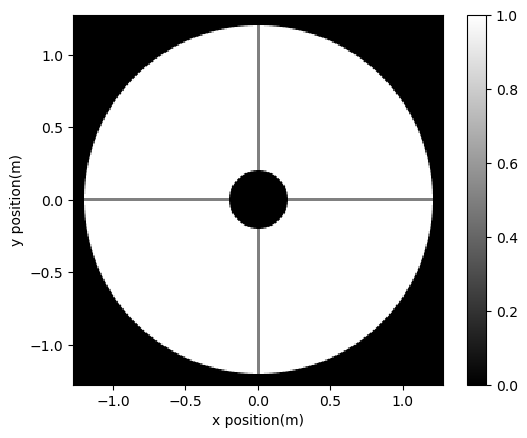

In [21]:
imshow_field(aperture, cmap='gray')
plt.xlabel('x position(m)')
plt.ylabel('y position(m)')
plt.colorbar()
plt.show()

## Generate wavefront from guidestar

In [19]:
wavelength_wfs = 0.6e-6
wavelength_sci = 0.6e-6 #what is this for?
flux_for_mag = lambda mag: 100**(0.2 * (mag - 0))

guide_star_mag = 10.0
star_flux = flux_for_mag(guide_star_mag)

print ('Star flux: {0}'.format(star_flux))

wf = Wavefront(aperture, wavelength_sci)
wf.total_power = star_flux

Star flux: 0.0001


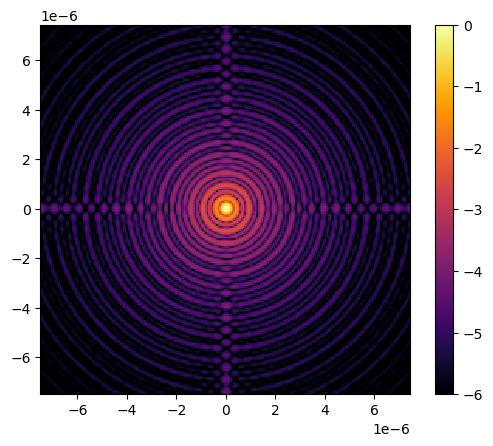

In [29]:
#checking the PSF (make sure wavefront is set up correctly?)

spatial_resolution = wavelength_sci / telescope_diameter
focal_grid = make_focal_grid(q=4, num_airy=30, spatial_resolution=spatial_resolution)

propagator = FraunhoferPropagator(pupil_grid, focal_grid)

unaberrated_PSF = propagator.forward(wf).power

imshow_field(np.log10(unaberrated_PSF / unaberrated_PSF.max()), cmap='inferno', vmin=-6)
plt.colorbar()
plt.show()

## Atmospheric turbulence

In [11]:
# need to add code here

## Set up AO & Wavefront Sensor

### Wavefront Sensor (SH)

change up the subapertures for the DM

In [ ]:
shwfs = SquareShackHartmannWavefrontSensorOptics(pupil_grid.scaled(magnification), f_number, \
                                                 num_lenslets, sh_diameter)
shwfse = ShackHartmannWavefrontSensorEstimator(shwfs.mla_grid, shwfs.micro_lens_array.mla_index)

### Deformable Mirror & Actuators

- test out the pattern of how the actuators are set up
- put a pattern of zernike modes on the DM to build an interaction matrix


In [10]:
f_number = 15
num_lenslets = 15 # 15 lenslets along one diameter
sh_diameter = telescope_diameter/num_lenslets #2.5/15 # m (that's the telescope diameter / actuators on one side)

magnification = sh_diameter / telescope_diameter
magnifier = Magnifier(magnification)

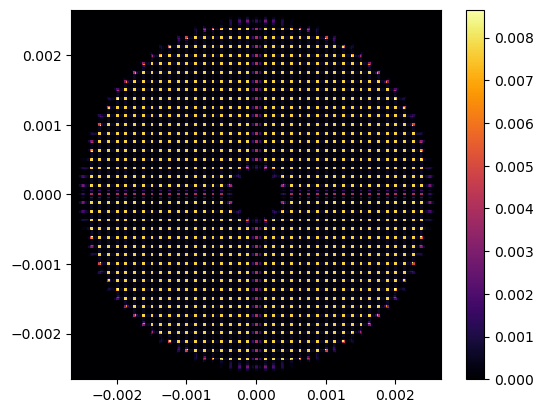

In [11]:
camera = NoiselessDetector(focal_grid)

wf = Wavefront(VLT_aperture, wavelength_wfs)
camera.integrate(shwfs(magnifier(wf)), 1)

image_ref = camera.read_out()

imshow_field(image_ref, cmap='inferno')
plt.colorbar()
plt.show()

In [20]:
fluxes = ndimage.sum(image_ref, shwfse.mla_index, shwfse.estimation_subapertures)
flux_limit = fluxes.max() * 0.5

estimation_subapertures = shwfs.mla_grid.zeros(dtype='bool')
estimation_subapertures[shwfse.estimation_subapertures[fluxes > flux_limit]] = True

shwfse = ShackHartmannWavefrontSensorEstimator(shwfs.mla_grid, shwfs.micro_lens_array.mla_index, estimation_subapertures)

In [ ]:
seeing = 1.5 #arcsec (r_naught=0.8m)